# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [2]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, \
                            roc_curve, precision_recall_curve, precision_score, recall_score
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# загрузка данных
data = pd.read_csv('/datasets/Churn.csv')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

(None, None)

In [4]:
# проверка наличия дубликатов
data.duplicated().sum()

0

In [5]:
# приведём названия столбцов к нижнему регистру и отредактируем некоторые из них
data.columns = data.columns.str.lower()
data.rename(columns = {'rownumber':'row_number',
                       'customerid':'customer_id',
                       'creditscore':'credit_score',
                       'numofproducts':'num_of_products',
                       'hascrcard':'has_cr_card',
                       'isactivemember':'is_active_member',
                       'estimatedsalary': 'estimated_salary'}, inplace = True) 

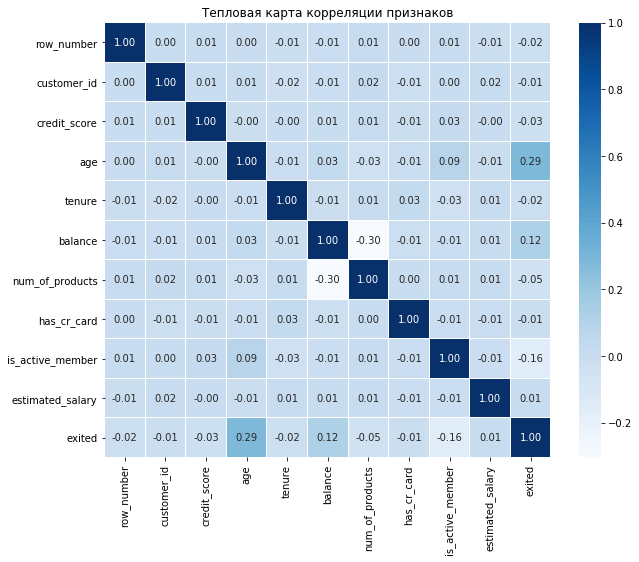

In [6]:
# для обработки пропусков полезно будет взглянуть на таблицу корреляции данных
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", linewidths=0.1, cmap='Blues')
plt.title('Тепловая карта корреляции признаков')
plt.show()

Таблица корреляции явно не указывает на признак, по которому можно восстановить пропуски в столбце количества недвижимости клиента.

Попробуем восстановить пропуски по предполагаемой зарплате.

In [7]:
# обработка пропусков 
data['salary_groups'] = pd.qcut(data['estimated_salary'], 10) # создадим новый столбец с инте
data['tenure'] = data.groupby('salary_groups')['tenure'].apply(lambda col: col.fillna(col.median()))
data['tenure'] = data['tenure'].astype(int)# приведём количество недвижимости к целочисленному типу
data.drop('salary_groups', axis=1, inplace=True)

* Данные загружены.

* Имена столбцов отредактированы и приведены к нижнему регистру.

* Признак с количеством недвижимости клиента содержит пропуски. Скорее всего ошибка при сборе данных и пропуск свидетельствует об отсутствии недвижимости. Заменим `0`.


In [8]:
# обработка категориальных признаков
data_ohe = pd.get_dummies(data, columns=['gender', 'geography'], drop_first=True)

In [16]:
# выделим признаки для обучения модели и целевой признак
features = data_ohe.drop(['row_number', 'customer_id', 'surname', 'exited'], axis=1)
target = data_ohe['exited']

# разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    stratify=target, # разделение с сохранением пропорции классов 
                                                    random_state=42)

print(f' X_train shape: {X_train.shape}\n',
      f'y_train shape: {y_train.shape}\n',
      f'X_test shape: {X_test.shape}\n',
      f'y_test shape: {y_test.shape}\n')

 X_train shape: (8000, 11)
 y_train shape: (8000,)
 X_test shape: (2000, 11)
 y_test shape: (2000,)



In [14]:
# обработка числовых признаков
numeric = ['credit_score', 'balance', 'age', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

* Обработал категориальные признаки, которые будут использоваться в обучении, методом `One-Hot-Encoding`.

* Разделил данные на обучающую и тестовую выборки.

* С помощью `StandartScaller`обработал числовые признаки. 

# 2. Исследование задачи

Проверим соотношение двух классов целевого признака в выборке:

Соотношение классов:


0    0.7963
1    0.2037
Name: exited, dtype: float64

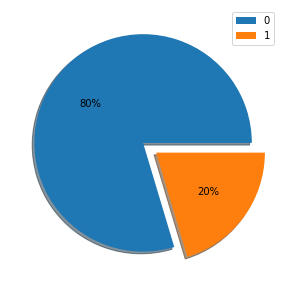

In [10]:
print('Соотношение классов:')
display(data['exited'].value_counts(normalize=True))

plt.figure(figsize=(5,5))
plt.pie(data['exited'].value_counts(), shadow=True, 
        explode=(0, 0.15), autopct='%1.f%%')
plt.legend(loc='best', labels=['0','1'], fontsize='medium')
plt.show()

Соотношение классов 1:4. В среднем 1 из 5 клиентов уходят из банка, согласно данной выборке.

Так как сохранение клиентов обходится банку дешевле, чем привлечение новых, для нас важно спрогнозировать и предотвратить уход клиента. 
Необходимо построить модель с высокой чувствительностью. Помимо точности(`precision`) модели, для нас так же большое значение имеет метрика полноты (`recall`).

Для оценки модели будем использовать `F1_меру`:

$$ F_1 = \frac{2 * Precision * Recall}{Precision + Recall} $$ 


In [17]:
models = []

models.append(['Dummy Classifier', DummyClassifier(strategy='stratified',random_state=42)])
models.append(['Decision Tree Classifier', DecisionTreeClassifier(random_state=42)])
models.append(['Random Forest Classifier', RandomForestClassifier(random_state=42)])
models.append(['Logistic Regression', LogisticRegression(random_state=42)])
models.append(['Support Vector Maschine', LinearSVC(random_state=42)])

for name, classifier in models:
    model = classifier.fit(X_train, y_train)
    predictions = cross_val_predict(classifier, X_train, y_train, cv=8)
    result = f1_score(y_train, predictions)
    
    
    conf_matrix = confusion_matrix(y_train, predictions)
    recall = conf_matrix[0, 0]/(conf_matrix[0, 0]+conf_matrix[1, 0])
    precision = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    
    print('{} F1: {:.3f}'.format(name, result))
    print(conf_matrix)
    print('Recall: {:.3f}'.format(recall))
    print('Precision: {:.3f}'.format(precision))
    print('_' * 30 + '\n')


Dummy Classifier F1: 0.207
[[5069 1301]
 [1291  339]]
Recall: 0.797
Precision: 0.796
______________________________

Decision Tree Classifier F1: 0.501
[[5503  867]
 [ 796  834]]
Recall: 0.874
Precision: 0.864
______________________________

Random Forest Classifier F1: 0.584
[[6135  235]
 [ 860  770]]
Recall: 0.877
Precision: 0.963
______________________________

Logistic Regression F1: 0.061
[[6273   97]
 [1576   54]]
Recall: 0.799
Precision: 0.985
______________________________

Support Vector Maschine F1: 0.236
[[5059 1311]
 [1236  394]]
Recall: 0.804
Precision: 0.794
______________________________



* Результаты получены при обучении моделей на данных без учёта дисбаланса классов. 

* Все модели проходят проверку адекватности в сравнении с оценкой DummyClassifier.

* Наибольший показатель `F1_меры` демонстрируют `Дерево Решений` и `Случайный Лес`.

# 3. Борьба с дисбалансом и тестирование модели

Протестируем два метода борьбы с дисбалансом `upsampling` и `взвешивание классов`.

Работать с дисбалансом будем предварительно подобрав лучшие параметры для модели случайного леса.

In [12]:
# взвешивание классов
forest_balanced = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

forest_params = {
    'n_estimators': range(10, 80, 10),
    'criterion':['gini', 'entropy'],
    'max_depth': range(5, 20, 1)
    }

forest_search = RandomizedSearchCV(forest_balanced, param_distributions=forest_params, 
                                   cv=10, scoring='f1', random_state=42)
forest_search.fit(X_train, y_train)
print('Лучшие параметры модели:', forest_search.best_params_)
print('_' * 20, '\n')
print('F1_score: {:.3f}'.format(forest_search.best_score_))

Лучшие параметры модели: {'n_estimators': 40, 'max_depth': 11, 'criterion': 'gini'}
____________________ 

F1_score: 0.615


In [13]:
# функция для upsampling-а
def upsample(x, y, repeat):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    x_upsampled, y_upsampled = shuffle(x_upsampled, 
                                       y_upsampled, 
                                       random_state=42)
    
    return x_upsampled, y_upsampled

X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 4)
print(y_train_upsampled.value_counts(normalize=True))

1    0.505818
0    0.494182
Name: exited, dtype: float64


In [14]:
# оценка модели с upsampling-ом
forest_ups = RandomForestClassifier(criterion='gini', n_estimators=40, 
                                max_depth=11, 
                                random_state=42, n_jobs=-1)
result = cross_val_score(forest_ups, X_train_upsampled, y_train_upsampled, cv=10, scoring='f1')
print('F1_score: {:.3f}'.format(result.mean()))

F1_score: 0.879


Возможно я где-то ошибся, но `upsampling` дал значительный прирост F1_меры - `0.879`

F1 для модели с лучшими гиперпараметрами при сбалансировании классов - `0.615`

# 4. Тестирование модели

In [15]:
forest_final = RandomForestClassifier(criterion='gini', n_estimators=40, 
                                max_depth=11, 
                                random_state=42, n_jobs=-1)
forest_final.fit(X_train_upsampled, y_train_upsampled)
print('F1_score: {:.3f}'.format(f1_score(y_test, forest_final.predict(X_test))))

F1_score: 0.618


При работе с тестовой выборкой модель превзошла заданный порог `F1 = 0.59`

Построим PR-кривую и посмотрим, как меняется соотношение этих метрик с изменением порога классификации.

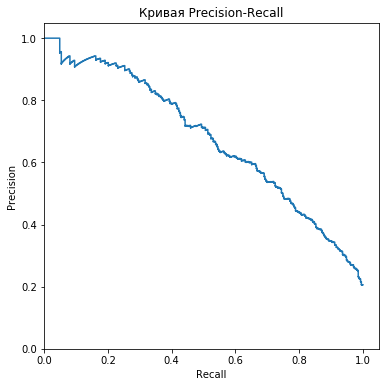

In [16]:
probabilities_valid = forest_final.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.show() 

In [17]:
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.42, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_test, predicted_valid)
    recall = recall_score(y_test, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.203 | Полнота = 1.000
Порог = 0.02 | Точность = 0.204 | Полнота = 1.000
Порог = 0.04 | Точность = 0.208 | Полнота = 0.995
Порог = 0.06 | Точность = 0.217 | Полнота = 0.993
Порог = 0.08 | Точность = 0.230 | Полнота = 0.988
Порог = 0.10 | Точность = 0.242 | Полнота = 0.985
Порог = 0.12 | Точность = 0.253 | Полнота = 0.983
Порог = 0.14 | Точность = 0.264 | Полнота = 0.973
Порог = 0.16 | Точность = 0.275 | Полнота = 0.961
Порог = 0.18 | Точность = 0.288 | Полнота = 0.948
Порог = 0.20 | Точность = 0.305 | Полнота = 0.936
Порог = 0.22 | Точность = 0.318 | Полнота = 0.926
Порог = 0.24 | Точность = 0.334 | Полнота = 0.914
Порог = 0.26 | Точность = 0.348 | Полнота = 0.894
Порог = 0.28 | Точность = 0.368 | Полнота = 0.877
Порог = 0.30 | Точность = 0.388 | Полнота = 0.860
Порог = 0.32 | Точность = 0.406 | Полнота = 0.848
Порог = 0.34 | Точность = 0.419 | Полнота = 0.830
Порог = 0.36 | Точность = 0.432 | Полнота = 0.816
Порог = 0.38 | Точность = 0.444 | Полнота = 0.791


Взглянем на метрику ROC AUC.

ROC_AUC Score: 0.858


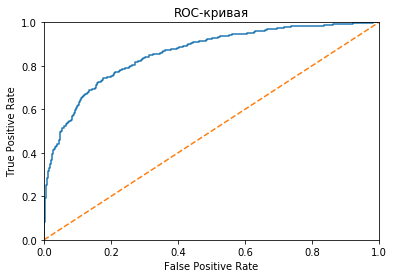

In [18]:
print('ROC_AUC Score: {:.3f}'.format(roc_auc_score(y_test, probabilities_valid[:, 1])))

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1) 
plt.ylim(0, 1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

**Вывод**


Итоговая модель дала нам высокую оценку `F1-меры = 0.618` и `ROC AUC = 0.858`.

Так как поиск новых пользователей для банка обходится дороже, чем удержание клиентов, нам необходима модель с высокой чувствительностью. При пороге классификации в `~20%` мы достигаем `~94%` полноты прогнозирования оттока клиентов при `~30%` точности. Это значит, что 94% клиентов, желающих расторгнуть договор с банком, будут обнаружены. При этом придётся низкая точность модели будет давать множество ложноположительных результатов. Стоит вести очень тонкую и ненавязчивую компанию по удержанию клиентов банка.